In [1]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import pairwise_distances

## user based collaborate filtering: pearson similarity 

* jaccard similarity can only measure whether a user is interested in something
* Jaccard cannot measure how a user is favor of sth
* Pearson can measure how a user is likely to rate a new item

#### read user-item scoring csv with frequency>30(avoid sparse)

In [2]:
original_dataframe = pd.read_csv("fil_6.csv")

fil_30_dataframe = original_dataframe.groupby('user').filter(lambda x:(x['user'].count()>30).any())

# obj_dataframe = fil_10_dataframe.pivot(index='user',columns='item',values='rating')

#### preprocess: fill na with 0

In [3]:
fil_30_dataframe = fil_30_dataframe.drop('Unnamed: 0',axis=1)
obj_df = fil_30_dataframe.fillna(0)
#obj_df.loc['A1P27BGF8NAI29']

In [4]:
agg_user_rating = obj_df.groupby('user').agg([list])

In [5]:
agg_item_rating = obj_df.groupby('item').agg([list])

In [6]:
#compute global mean
g_mean = obj_df['rating'].mean()
g_mean

4.231606028155771

In [7]:
# initialize bias for user and item
b_user = dict(zip(agg_user_rating.index,np.zeros(len(agg_user_rating.index))))

b_item = dict(zip(agg_item_rating.index,np.zeros(len(agg_item_rating.index))))

#b_user

In [8]:
list(obj_df.itertuples(index=False))

[Pandas(user='AMBJQQSRCAOHS', item='0615315860', rating=5.0),
 Pandas(user='A1P27BGF8NAI29', item='0705394638', rating=5.0),
 Pandas(user='A1YUL9PCJR3JTY', item='1574899171', rating=5.0),
 Pandas(user='A1YUL9PCJR3JTY', item='157489918X', rating=5.0),
 Pandas(user='A1YUL9PCJR3JTY', item='1574899201', rating=5.0),
 Pandas(user='A1YUL9PCJR3JTY', item='157489921X', rating=5.0),
 Pandas(user='A38RMU1Y5TDP9', item='159985130X', rating=4.0),
 Pandas(user='AXO4PQU0XG3TG', item='159985130X', rating=5.0),
 Pandas(user='A3IUW081KXD3PE', item='159985130X', rating=5.0),
 Pandas(user='A17V9XL4CWTQ6G', item='1933622865', rating=5.0),
 Pandas(user='A3G158QI50PQA3', item='1933622865', rating=5.0),
 Pandas(user='A35W3JQYP0M655', item='1933622865', rating=1.0),
 Pandas(user='AA0YPCLUF78B4', item='1933937521', rating=5.0),
 Pandas(user='A297R44X7WEQ8T', item='1935009656', rating=4.0),
 Pandas(user='A1EXGL6L0QQ0M5', item='3812028492', rating=4.0),
 Pandas(user='A3CJXEJD0720F2', item='6035002307', rating=5.

In [9]:
# apply gradient descent optimizer
# 10 epochs
epochs = 10
learning_rate = 0.1
reg_coef = 0.1
for i in range(epochs):
    print("epoch%d"%i)
    for user,item,rating in obj_df.itertuples(index=False):
        cost = rating-(g_mean+b_user[user]+b_item[item])
        #b_user[user] regularization
        b_user[user] += learning_rate*(cost-reg_coef*b_user[user])
        b_item[item] += learning_rate*(cost-reg_coef*b_item[item])

epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9


In [10]:
#b_user

In [11]:
#b_item

In [12]:
# predict rating

def predict(user,item,global_mean):
    predict_rating = global_mean+b_user[user]+b_item[item]
    return predict_rating

In [13]:
predict('A100UD67AHFODS','0615315860',g_mean)

4.873126032191038

In [14]:
def gradient_descent(agg_user_rating,agg_item_rating,g_mean,rating_matrix,epoch):
    b_user = dict(zip(agg_user_rating.index,np.zeros(len(agg_user_rating))))
    b_item = dict(zip(agg_item_rating.index,np.zeros(len(agg_item_rating))))
    for i in range(epoch):
        print("epoch%d"%i)
        for user, item, rating in rating_matrix.itertuples(index=False):
            cost = rating-(g_mean+b_user[user]+b_item[item])
            b_user[user] += learning_rate*(cost-learning_rate*b_user[user])
            b_item[item] += learning_rate*(cost-learning_rate*b_item[item])
    return (b_user,b_item)

In [15]:
#gradient_descent(agg_user_rating,agg_item_rating,g_mean,obj_df,10)

In [16]:
def integrate(user,item,rating,rating_matrix):
    agg_user_rating = obj_df.groupby(user).agg([list])
    agg_item_rating = obj_df.groupby(item).agg([list])
    g_mean = obj_df[rating].mean()
    b_user,b_item = gradient_descent(agg_user_rating,agg_item_rating,g_mean,rating_matrix,30)
    return b_user,b_item

In [17]:
#integrate('user','item','rating',obj_df)

In [18]:
def integrate_predict(user,item,rating_matrix):
    b_user,b_item = integrate('user','item','rating',rating_matrix)
    result_rating = obj_df['rating'].mean() +b_user[user]+b_item[item]
    return result_rating

In [19]:
integrate_predict('A100UD67AHFODS','B00014FAAK',obj_df)

epoch0
epoch1
epoch2
epoch3
epoch4
epoch5
epoch6
epoch7
epoch8
epoch9
epoch10
epoch11
epoch12
epoch13
epoch14
epoch15
epoch16
epoch17
epoch18
epoch19
epoch20
epoch21
epoch22
epoch23
epoch24
epoch25
epoch26
epoch27
epoch28
epoch29


1.569330701795661

In [20]:
# try to measure acc


In [21]:
def train_test_split(rating_matrix,train_ratio):
    train_index = list()
    test_index = list()
    for user in rating_matrix.groupby('user').any().index:
        u_rating = rating_matrix.where(rating_matrix["user"]==user).dropna()
        # note: convert to list before shuffle
        rating_index = list(u_rating.index)
        np.random.shuffle(rating_index)    
        test_index += list(rating_index[round(len(u_rating) * train_ratio):])
        
    test = rating_matrix.loc[test_index]
    train = rating_matrix.drop(test_index)
    return train,test

In [22]:
train, test = train_test_split(obj_df,0.9)

In [23]:
def test_generator(test_ds):
    for user,item,rating in test_ds.itertuples(index=False):
        try:
            #pred = integrate_predict(user, item,test_ds)
            pred = predict(user, item,g_mean)
        except Exception as e:
            print(e)
        else:
            yield user, item, rating, pred

In [24]:
def measure_rmse(test_gene):
    count = 0
    result = 0
    for user, item, truth, pred in test_gene:
        count += 1
        result += (truth - pred) ** 2
    return round(np.sqrt(result / count), 2)

In [25]:
def measure_mae(test_gene):
    count = 0
    result = 0
    for user, item, truth, pred in test_gene:
        count += 1
        result += abs(truth - pred)
    return round(result / count, 2)

In [26]:
def measure_rmse_mae(test_gene):
    count = 0
    rmse = 0
    mae = 0
    for user, item, truth, pred in test_gene:
        count += 1
        rmse += (truth - pred) ** 2
        mae += abs(truth - pred)
    return round(np.sqrt(rmse / count), 10), round(mae / count, 10)

In [27]:
test_ds = test_generator(test)

In [28]:
# warning: huge time consumption
measure_rmse_mae(test_ds)

(0.7426160061, 0.5424476322)

In [29]:
def combineMetric(test_gene):
    count = 0
    rmse = 0
    mae = 0
    SSE=0
    SST=0
    sum_truth = 0
    truth_list = []
    for user, item, truth, pred in test_gene:
        count += 1
        rmse += (truth - pred) ** 2
        #print("truth %f pred %f"%(truth,pred))
        mae += abs(truth - pred)
        SSE += (truth - pred) ** 2
        truth_list.append(truth)
    mean_truth = sum_truth/count
    for pred in truth_list:
        SST+= (pred-mean_truth)**2
    return round(np.sqrt(rmse / count), 2), round(mae / count, 2),round(1-(SSE/SST),2)

In [30]:
test_ds = test_generator(test)
combineMetric(test_ds)

(0.74, 0.54, 0.97)

In [31]:
def predict_plot(user,item,user_bias,item_bias,g_mean):
    predict_rating = g_mean+user_bias[user]+item_bias[item]
    return predict_rating

def test_generator_plot(test_ds,user_bias,item_bias,g_mean):
    for user,item,rating in test_ds.itertuples(index=False):
        try:
            #pred = integrate_predict(user, item,test_ds)
            pred = predict_plot(user,item,user_bias,item_bias,g_mean)
        except Exception as e:
            print(e)
        else:
            yield user, item, rating, pred

# def integrate_SGD(epochs,learning_rate,reg_coef,obj_df,test):
#     #initial user and item bias
#     b_user = dict(zip(agg_user_rating.index,np.zeros(len(agg_user_rating))))
#     b_item = dict(zip(agg_item_rating.index,np.zeros(len(agg_item_rating))))
#     g_mean = obj_df['rating'].mean()
#     # update user and item bias
#     for i in range(epochs):
#         #print("epoch%d"%i)
#         for user,item,rating in obj_df.itertuples(index=False):
#             cost = rating-(g_mean+b_user[user]+b_item[item])
#             #b_user[user] regularization
#             b_user[user] += learning_rate*(cost-reg_coef*b_user[user])
#             b_item[item] += learning_rate*(cost-reg_coef*b_item[item])
#     test_ds = test_generator(test)
#     return measure_rmse_mae(test_ds)

def integrate_SGD(epochs,learning_rate,reg_coef,obj_df,test):
    #initial user and item bias
    b_user = dict(zip(agg_user_rating.index,np.ones(len(agg_user_rating))))
    b_item = dict(zip(agg_item_rating.index,np.ones(len(agg_item_rating))))
    g_mean = obj_df['rating'].mean()
    # update user and item bias
    for i in range(epochs):
        #print("epoch%d"%i)
        for user,item,rating in obj_df.itertuples(index=False):
            cost = rating-(g_mean+b_user[user]+b_item[item])
            #b_user[user] regularization
            b_user[user] += learning_rate*(cost-reg_coef*b_user[user])
            b_item[item] += learning_rate*(cost-reg_coef*b_item[item])
    test_ds = test_generator_plot(test,b_user,b_item,g_mean)
    return measure_rmse_mae(test_ds)

In [32]:
#integrate_SGD(100,0.01,0.01,obj_df,test)

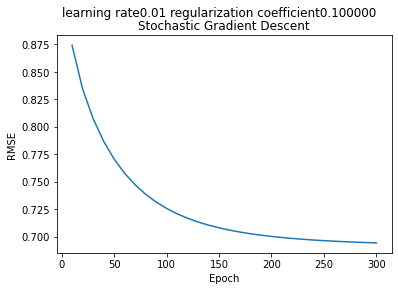

In [33]:
import matplotlib.pyplot as plt
x = [10*i for i in range(1,31)]
y = list()
for i in x:
    y.append(integrate_SGD(i,0.01,0.1,obj_df,test)[0])
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.suptitle('learning rate%.2f regularization coefficient%2f'%(0.01,0.1))
plt.plot(x,y)
plt.title('Stochastic Gradient Descent') 
plt.show()

In [ ]:
x = [10*i for i in range(1,31)]
y = list()
for i in x:
    y.append(integrate_SGD(i,0.01,0.1,obj_df,test)[1])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.plot(x,y)
plt.suptitle('learning rate%.2f regularization coefficient%2f'%(0.01,0.1))
plt.title('Stochastic Gradient Descent') 
plt.show()

In [ ]:
import matplotlib.pyplot as plt
x = [10*i for i in range(1,31)]
y = list()
for i in x:
    y.append(integrate_SGD(i,0.001,0.1,obj_df,test)[0])
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.suptitle('learning rate%.2f regularization coefficient%2f'%(0.001,0.1))
plt.plot(x,y)
plt.title('Stochastic Gradient Descent') 
plt.show()

In [ ]:
x = [10*i for i in range(1,31)]
y = list()
for i in x:
    y.append(integrate_SGD(i,0.001,0.1,obj_df,test)[1])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.plot(x,y)
plt.suptitle('learning rate%.2f regularization coefficient%2f'%(0.001,0.1))
plt.title('Stochastic Gradient Descent') 
plt.show()